In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import spectral_analysis as sa
import glob
import pickle
from math import *

In [2]:
spec_pkls = glob.glob('../../SALT3/output_for_snana/*.pkl')

In [3]:
def gsmooth(x_array, y_array, var_y, vexp , nsig = 5.0):
    """Function gsmooth() is an inverse variance weighted Gaussian smoothing of spectra
       Optional imputs are smoothing velocity (vexp) and number of sigma (nsig)
       Syntax: new_y_array = gsmooth(x_array, y_array, var_y, vexp = 0.01, nsig = 5.0)
    """
    
    # Check for zero variance points, and set to 1E-20

    if var_y is None:
        var_y = 1.e-31*np.ones(len(y_array))
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

def find_vexp(x_array, y_array, var_y=None):
    if var_y is not None:
        error = np.sqrt(var_y)
        new_y_init = gsmooth(x_array, y_array, var_y, .002)
        SNR = np.median(new_y_init / error)
    else:
        new_y_init = gsmooth(x_array, y_array, var_y, .002) #this smoothing should get in right ballpark
        error = np.absolute(y_array - new_y_init)
        sm_error = gsmooth(x_array, error, var_y, .008)
        SNR = np.median(new_y_init / sm_error)


    #TODO: interpolate a function of SNR
    # vexp_line = np.polyfit([2.5, 80], [.0045, .001], 1)
    # coeff_0 = vexp_line[0]
    # coeff_1 = vexp_line[1]
    # results from above:
    coeff_0 = -4.51612903e-05
    coeff_1 = 4.61290323e-03
    vexp_auto = coeff_0*SNR + coeff_1

    if SNR < 2.5:
        vexp_auto = .0045
    if SNR > 80:
        vexp_auto = .001
    
    dw = np.median(np.diff(x_array))
    if dw >=4:
        vexp_auto = .0045
        
    return vexp_auto, SNR

In [4]:
def genivar(wavelength, flux, varflux, vexp = 0.002, nsig = 5.0, testing=False, sky=False, source=None):
    """ The primary function for variance spectrum generation. Spectrum is smoothed, residual spectrum 
        is generated, residual spectrum is smoothed, sky noise is added in, error spectrum is scaled
        by a linear function of wavelength determined from the CfA data, and the ivar spectrum and SNR 
        are returned.
    """

    if varflux is not None and not testing:
        error = np.sqrt(varflux)
        SNR = np.median(flux / error)
        ivar = 1. / (varflux)
        return ivar, SNR

    # Smooth original flux

    new_flux = gsmooth(wavelength, flux, varflux, vexp, nsig)
    
    # Generate absolute value of the noise from original flux
    error = abs(flux - new_flux)
    
    # Smooth noise to find the variance
    sm_error = gsmooth(wavelength, error, varflux, .015, nsig)

    # Test wavelength ranges for kecksky overlap
    test1 = np.where((wavelength >= 5000) & (wavelength <= 6000))
    test2 = np.where((wavelength >= 6000) & (wavelength <= 7000))
    test3 = np.where((wavelength >= 7000) & (wavelength <= 8000))

    if sky:
        if len(test1[0]) > 40:
            med_err = np.median(sm_error[test1])
            sm_error_new = addsky(wavelength, flux, sm_error, med_err, source=source)
        elif len(test2[0]) > 40:
            med_err = np.median(sm_error[test2])
            sm_error_new = addsky(wavelength, flux, sm_error, med_err, source=source)
        elif len(test3[0]) > 40:
            med_err = np.median(sm_error[test3])
            sm_error_new = addsky(wavelength, flux, sm_error, med_err, source=source)
        else:
            sm_error_new = sm_error
    else:
        sm_error_new = sm_error

    if varflux is not None:
        real_error = np.sqrt(varflux)
        sm_real_error = gsmooth(wavelength, real_error, None, .008)
        error_scales = sm_real_error/sm_error
        scale_fit = np.polyfit(wavelength, error_scales, 1)
        scale_func = scale_fit[0]*(wavelength) + scale_fit[1]
    

    scale_func = -5.01307400136e-05*(wavelength) + 1.61999679746 #RESULTING COEFFS FROM RECENT FITS
    scaled_error = scale_func*sm_error_new

    if testing:
        scale = 1.
        plt.rc('font', family='serif')
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10, 8, forward = True)
        plt.minorticks_on()
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.tick_params(
            which='major', 
            bottom='on', 
            top='on',
            left='on',
            right='on',
            length=10)
        plt.tick_params(
            which='minor', 
            bottom='on', 
            top='on',
            left='on',
            right='on',
            length=5)

        plt.plot(wavelength, scale*error, linewidth = 2, color = '#000080', label='Absolute Residuals')
        plt.plot(wavelength, scale*sm_error_new, linewidth = 2, color = 'orange', label='Smoothed Absolute Residuals')
        plt.plot(wavelength, scale*scale_func*sm_error_new, linewidth = 2, color = 'magenta', label='Smoothed Absolute Residuals Corrected')
        if varflux is not None:
            plt.plot(wavelength, scale*real_error, linewidth = 2, color = 'g', label='Real Uncertainty')
        plt.ylabel('Uncertainty (Scaled Flux)', fontsize = 30)
        plt.xlabel('Rest Wavelength ' + "($\mathrm{\AA}$)", fontsize = 30)
        plt.xlim([wavelength[0]-200,wavelength[-1]+200])
        plt.legend(loc=1, fontsize=20)
        # plt.savefig('../../../Paper_Drafts/reprocessing_updated/genvar.pdf', dpi = 300, bbox_inches = 'tight')
        plt.show()
        if varflux is not None:
            plt.plot(wavelength, error_scales)
            plt.plot(wavelength, scale_func)
            plt.show()
            
    sm_var_new = scaled_error*scaled_error

    # Inverse variance
    ivar = 1./(sm_var_new)
    SNR = np.median(new_flux / scaled_error)
    return scaled_error, SNR

SN2020UXZ_59175.flm
4749 4749


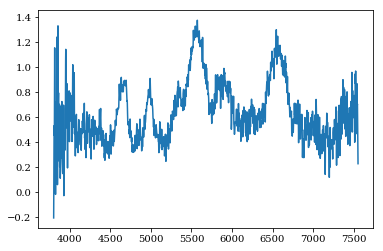

0.003995048987193241 13.681058240418748


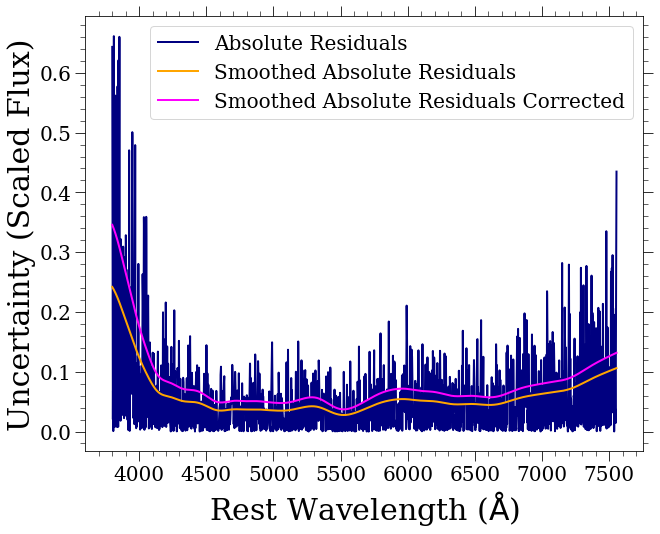

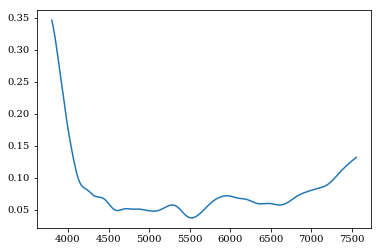

In [18]:
# phot,spec = pickle.load(open('../../SALT3/output_for_snana/SN2020EES.pkl','rb'))
dws = []
for dat in spec_pkls:
    phot,spec = pickle.load(open(dat,'rb'))
    for date in spec.keys():
        if '59175' in str(date):
            new_file = dat.split('/')[-1].split('.')[0] + '_' + str(date).split('.')[0] + '.flm'
            print (new_file)
            wavelength = spec[date]['wavelength']
            flux = spec[date]['flux']
            
            wave_new = wavelength[(wavelength > 3800) & (wavelength < 7555)]
            flux_new = flux[(wavelength > 3800) & (wavelength < 7555)]
            plt.plot(wave_new,flux_new)
            print (len(wave_new), len(flux_new))
            plt.show()
            
            vexp_auto, SNR = find_vexp(wave_new, flux_new, var_y=None)
            print (vexp_auto, SNR)
            
            
            flux_unc, SNR = genivar(wave_new, flux_new, None, vexp = vexp_auto, nsig = 5.0, testing=True, sky=False, source=None)
            plt.plot(wave_new,flux_unc)
            plt.show()
            np.savetxt('../../SALT3/output_for_snana/updated_spectra/'+ new_file, np.transpose([wave_new,flux_new,flux_unc]))
        
        

(array([23., 56.,  3.,  3.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  7.]),
 array([ 0.791  ,  2.03145,  3.2719 ,  4.51235,  5.7528 ,  6.99325,
         8.2337 ,  9.47415, 10.7146 , 11.95505, 13.1955 , 14.43595,
        15.6764 , 16.91685, 18.1573 , 19.39775, 20.6382 , 21.87865,
        23.1191 , 24.35955, 25.6    ]),
 <a list of 20 Patch objects>)

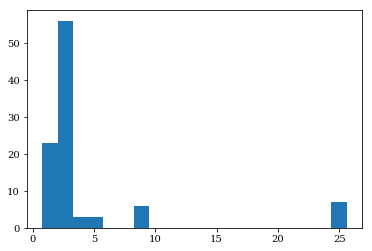

In [50]:
plt.hist(dws, bins =20)